TODOs:

* Searching for keywords, finding tweets in a geographic area, search for term in an area
* Collect content
* Tools for bot-detector: bot-o-meter
* Rehydrating
* Pulling replies to a tweet
* EU & China data privacy considerations for tweets?
* 

# Web Data Scraping

[Spring 2019 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Class outline

* **Week 1**: Introduction to Jupyter, browser console, structured data, ethical considerations
* **Week 2**: Scraping HTML with `requests` and `BeautifulSoup`
* **Week 3**: Scraping an API with `requests` and `json`, Wikipedia
* **Week 4**: Scraping web data with Selenium and using the Internet Archive API
* **Week 5**: Scraping data from Twitter

## Acknowledgements

Thank you also to Professors [Bhuvana Narasimhan](https://www.colorado.edu/linguistics/bhuvana-narasimhan) and [Stefanie Mollborn](https://behavioralscience.colorado.edu/person/stefanie-mollborn) for coordinating the ITSS seminars.

## Class 5 goals

* Sharing accomplishments and challenges with last week's material
* Using the `python-twitter` wrapper library to handle authentication
* Retrieving and parsing a single tweet
* Rehydrating a list of tweet IDs
* Pulling a user's timeline
* Pulling a user's friend and follower lists
* Detecting bot accounts using IU's Bot-o-Meter

Start with our usual suspect packages.

In [1]:
# Lets Jupyter Notebook display images in-line
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Import our helper libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import quote, unquote

# Import the VADER sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the model
sia = SentimentIntensityAnalyzer()

/Users/briankeegan/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Installing a Twitter API wrapper

As was the case with Reddit, we will take advantage of a wrapper library to handle the heavy lifting of authenticating, making specific requests, handling rate-limiting, *etc*. There are no shortage of Python wrappers for the Twitter API, but the most popular are:

* [python-twitter](https://python-twitter.readthedocs.io/en/latest/)
* [Tweepy](http://docs.tweepy.org/en/latest/)
* [Twython](https://twython.readthedocs.io/en/latest/)

There are other wrapper libraries linked from the [Twitter developer utilities documentation](https://developer.twitter.com/en/docs/developer-utilities/twitter-libraries.html).

I'm going to use `python-twitter` just because it's more lightweight, but the glaring lack of examples and tutorials in the documentation is disappointing.

You will need to install this since it does not come with conda by default. At the Terminal:

`pip install python-twitter`

Once you've installed it, you can import the `twitter` wrapper library.

In [2]:
import twitter

## Authenticating
I don't want to share my Twitter credentials with the world, so I load from from my local machine. If you wanted to do this, it should take this format of:

```
{"consumer_key":"API key",
 "consumer_secret":"API secret key",
 "access_token_key":"Access token",
 "access_token_secret":"Access token secret"
}
```

In [3]:
# Load my key information from disk
with open('twitter_keys.json','r') as f:
    twitter_keys = json.load(f)

# Authenticate with the Twitter API using the twitter_keys dictionary
# The "tweet_mode='extended' allows us to see the full 280 characters in tweets
api = twitter.Api(**twitter_keys,tweet_mode='extended')

Alternatively, you can just enter your keys directly into the `Api` function.

In [4]:
api = twitter.Api(consumer_key = 'API key',
                  consumer_secret = 'API secret key',
                  access_token_key = 'Access token',
                  access_token_secret = 'Access token secret',
                  tweet_mode='extended')

Test that you can connect to the API.

In [4]:
api.GetUser(screen_name='realdonaldtrump')

User(ID=25073877, ScreenName=realDonaldTrump)

## Getting the payload of a single tweet

Wikipedia helpfully maintains a [List of most-retweeted tweets](https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets). Go to one of the tweets and pull out the ID at the end of the URL.

In [5]:
tweet = api.GetStatus('849813577770778624')

This returns a `Status` object. If we want the raw data inside this `Status` object, we can use the `.AsDict()` function.

In [6]:
tweet.AsDict()

{'created_at': 'Thu Apr 06 02:38:40 +0000 2017',
 'favorite_count': 989244,
 'full_text': 'HELP ME PLEASE. A MAN NEEDS HIS NUGGS https://t.co/4SrfHmEMo3',
 'hashtags': [],
 'id': 849813577770778624,
 'id_str': '849813577770778624',
 'lang': 'en',
 'media': [{'display_url': 'pic.twitter.com/4SrfHmEMo3',
   'expanded_url': 'https://twitter.com/carterjwm/status/849813577770778624/photo/1',
   'id': 849813572351737856,
   'media_url': 'http://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg',
   'sizes': {'small': {'w': 382, 'h': 680, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'medium': {'w': 675, 'h': 1200, 'resize': 'fit'},
    'large': {'w': 750, 'h': 1334, 'resize': 'fit'}},
   'type': 'photo',
   'url': 'https://t.co/4SrfHmEMo3'}],
 'retweet_count': 3536832,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'urls': [],
 'user': {'created_at': 

There are other attributes we can access directly from the object rather than having to navigate the JSON structure. Your ability to access these attributes is a function of the `python-twitter` library rather than the raw data returned by the Twitter API, so I would prefer to work with the JSON in the interests of forward compatibility, but you do you. Here's how to access via the attributes of a `Status` object returned by `python-twitter`.

In [7]:
# When was the tweet created?
tweet.created_at

'Thu Apr 06 02:38:40 +0000 2017'

In [8]:
# Number of favorites (at the time of the API call)
tweet.favorite_count

989244

In [9]:
# Number of retweets (at the time of the API call)
tweet.retweet_count

3536832

In [10]:
# Text of the tweet
tweet.full_text

'HELP ME PLEASE. A MAN NEEDS HIS NUGGS https://t.co/4SrfHmEMo3'

In [11]:
# Location (if it geo-located)
tweet.geo

In [12]:
# List of hashtags present
tweet.hashtags

[]

In [13]:
# Tweet ID
tweet.id

849813577770778624

In [14]:
# A guess at the language of the tweet
tweet.lang

'en'

These next two attributes return `User` and `Media` objects rather than simple strings, ints, *etc*. that have their own attributes and methods.

In [15]:
tweet.user

User(ID=2568270758, ScreenName=carterjwm)

We can access attributes of this `User` object.

In [16]:
# Screen name of the user
tweet.user.screen_name

'carterjwm'

In [17]:
# Displayed name of the user
tweet.user.name

'Carter Wilkerson'

In [18]:
# User biography
tweet.user.description

'I kinda like chicken nuggets'

In [19]:
# Account creation time
tweet.user.created_at

'Sun Jun 15 03:48:03 +0000 2014'

In [20]:
# Self-reported location
tweet.user.location

'Reno, NV - San Diego, CA'

In [21]:
# Number of tweets from the user
tweet.user.statuses_count

1723

In [22]:
# Number of followers
tweet.user.followers_count

100369

In [23]:
# Number of friends (accounts this account follows, followees, etc.)
tweet.user.friends_count

287

Similarly, the `Media` object inside this list contains information about the type and the URLs of the media inside this object. If there were multiple images in this tweet, there would be a `Media` item in the list for each of them.

In [24]:
tweet.media[0].type

'photo'

In [25]:
tweet.media[0].media_url

'http://pbs.twimg.com/media/C8sk8QlUwAAR3qI.jpg'

## Rehydrating a list of tweets

Twitter's Terms of Service do not allow datasets of statuses to be shared, but researchers are permitted to share the identifiers for tweets in their datasets. Researchers then need to "rehydrate" these statuses by requesting the full payloads from Twitter's API. A list of resources with links to tweet IDs used in research:

* [DocNow's Tweet ID Datasets](https://www.docnow.io/catalog/)
* [FollowTheHashtag's Free Twitter Datasets](http://followthehashtag.com/datasets/)
* [AcademicTorrents](http://academictorrents.com/browse.php?search=twitter)
* [FiveThirtyEight's Russian Troll Tweets](https://github.com/fivethirtyeight/russian-troll-tweets/)
* [Harvard Dataverse](https://dataverse.harvard.edu/dataverse/harvard?q=twitter&types=datasets&sort=score&order=desc&page=1)

This has some privacy benefits: Twitter's [compliance statement](https://developer.twitter.com/en/docs/tweets/compliance/overview) describes that users should retain the option to delete tweets or their accounts and this rehydration arrangement—theoretically—prevents their tweet content from circulating without their consent. In practice, many of the largest Twitter corpora come from the streaming API (more on that later in this notebook) and Twitter has a "[compliance stream](https://developer.twitter.com/en/docs/tweets/compliance/api-reference/compliance-firehose)" that indicates that a user has deleted a tweet, protected their account, Twitter has suspended an account, Twitter has withheld the status, *etc*. and the tweet should be removed from your streaming dataset as well. The Sunlight Foundation and ProPublica maintain a list of deleted tweets from politicians called [Politiwoops](https://projects.propublica.org/politwoops/).

I am going to use a [list of tweets made by Senators in the 115th Congress](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UIVHQR) collected by Justin Littman in 2017. Load the text file:

In [26]:
with open('senators-115th.txt','r') as f:
    senators_tweet_ids = [tweet_id.strip() for tweet_id in f.readlines()]
    
"There are {0:,} tweets IDs in the file.".format(len(senators_tweet_ids))

'There are 519,210 tweets IDs in the file.'

Look at the first 10 statuses.

In [27]:
senators_tweet_ids[:10]

['942793432321462273',
 '942513647695351808',
 '942439827970183169',
 '942419102597107713',
 '942419087833092096',
 '942403862673215488',
 '942402966673395713',
 '942402245991260160',
 '942401802628104197',
 '942399780008923138']

Use the `GetStatuses` function, which accepts a dictionary of status IDs in order to hydrate this list of tweets. We will use the "`map=True`" parameter to keep track of any tweets that were not returned (which should be `None`s rather than `Status`es).

Now for a bit of accounting on rate limits. According to the API documentation for [get statuses/lookup](https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-lookup), you can ask for up to 100 tweets per request and you can make 900 requests per 15-minutes. This means you can theoretically rehydrate 90,000 tweets per 15 minutes, or 360,000 tweets per hour. So it would take approximately 90 minutes to rehydrate all 500,000 of these senators' tweets.

In [28]:
senators_10_tweets = api.GetStatuses(senators_tweet_ids[:10],map=True)

There should be 10 `Status` objects returned by the API.

In [29]:
len(senators_10_tweets)

10

Write a loop to go through the ten tweets and print out information.

In [30]:
for status in senators_10_tweets.values():
    if type(status) == twitter.models.Status:
        screen_name = status.user.screen_name
        created = pd.to_datetime(status.created_at)
        text = status.full_text
        retweets = status.retweet_count
        formatted_str = '{0} on {1} said {2}, which received {3} retweets.\n'
        print(formatted_str.format(screen_name,created,text,retweets))

DougJones on 2017-12-17 14:23:11+00:00 said "Everyone needs to hit the political reset button and examine issues in a way that best helps the people of Alabama.", which received 292 retweets.

DougJones on 2017-12-17 21:55:39+00:00 said “I think there’s an opportunity at every turn,” he said on “Fox News Sunday” before adding such cooperation is a “two-way street.” https://t.co/b8CVmgvQG5, which received 251 retweets.

DougJones on 2017-12-17 15:39:54+00:00 said RT @CBSSunday: "When you're on the right side of history you can accomplish a lot of things, " says Alabama senator-elect @GDouglasJones 
#…, which received 303 retweets.

DougJones on 2017-12-17 15:39:58+00:00 said RT @CBSSunday: .@BojorquezCBS: Do you think you would have won had @washingtonpost not broken the story about sexual misconduct allegations…, which received 98 retweets.

DougJones on 2017-12-17 14:35:50+00:00 said Doug on Senate #tax bill: "I have real concerns about a tax plan that would add $1 trillion to the nat

Alternatively, extract the relevant fields, save these as a list of dictionaries, and convert the list of dictionaries to a DataFrame. Note that when an account retweets another account, a second `Status` object is embedded under the "`.retweeted_status`" attribute that contains the parent tweet's information. In these cases, the "`.created_at`" from the Senator's account is when s/he retweeted the status and the "`.created_at`" for the "`.retweeted_status`" is when the parent tweet was first posted.

In [31]:
statuses_list = []

for status in senators_10_tweets.values():
    if type(status) == twitter.models.Status:
        payload = {}
        payload['screen_name'] = status.user.screen_name
        payload['created'] = pd.to_datetime(status.created_at)
        payload['retweets'] = status.retweet_count
        payload['favorites'] = status.favorite_count
        
        # If an account retweets another account, we should store that information
        if status.retweeted_status == None:
            payload['text'] = status.full_text
            payload['retweeted'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False
        else:
            payload['text'] = status.retweeted_status.full_text
            payload['retweeted'] = True
            payload['retweeted_screen_name'] = status.retweeted_status.user.screen_name
            payload['retweeted_created'] = status.retweeted_status.created_at
        
        statuses_list.append(payload)
        
df = pd.DataFrame(statuses_list)
df

,created,favorites,retweeted,retweeted_created,retweeted_screen_name,retweets,screen_name,text
0,2017-12-17 14:23:11+00:00,1973,False,False,False,292,DougJones,"""Everyone needs to hit the political reset but..."
1,2017-12-17 21:55:39+00:00,1268,False,False,False,251,DougJones,"“I think there’s an opportunity at every turn,..."
2,2017-12-17 15:39:54+00:00,0,True,Sun Dec 17 15:33:45 +0000 2017,CBSSunday,303,DougJones,"""When you're on the right side of history you ..."
3,2017-12-17 15:39:58+00:00,0,True,Sun Dec 17 15:24:11 +0000 2017,CBSSunday,98,DougJones,.@BojorquezCBS: Do you think you would have wo...
4,2017-12-17 14:35:50+00:00,1747,False,False,False,437,DougJones,"Doug on Senate #tax bill: ""I have real concern..."
5,2017-12-17 14:31:13+00:00,429,False,False,False,73,DougJones,Up next: Doug joins Chris Wallace on Fox News ...
6,2017-12-17 14:39:24+00:00,15924,False,False,False,2293,DougJones,"""I have resisted trying putting labels on myse..."
7,2017-12-17 14:32:59+00:00,3634,False,False,False,442,DougJones,"""I think there's opportunity at every turn to ..."
8,2017-12-17 17:02:19+00:00,1446,False,False,False,315,DougJones,"""I can work w/ the President... when I talk ab..."
9,2017-12-18 16:27:25+00:00,1088,False,False,False,190,DougJones,"""It doesn't matter what the issue is. There's ..."


## Pulling a user's timeline

In the previous class, we wrote a screen-scraper to retrieve the tweet timelines of government officials. This broke Twitter's Terms of Service but is probably defensible under emerging legal precedents applying public forum doctrine and government speech to these accounts. 

In general, if you want to retrieve the tweets from a user's timeline, we can use Twitter's API to get the 3,200 most recent tweets from the [get statuses/user_timeline](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) API endpoint. This will include retweets of other statuses. We can retrieve up to 200 tweets per request and can make 900 requests per 15-minute window, so we can get 18,000 tweets per window or 72,000 tweets per hour. This means we could theoretically get up to 22 users' most recent 3,200 tweets per hour.

Alexandria Ocasio-Cortez has written 6,975 tweets on her personal account, "[AOC](https://twitter.com/aoc)". She also has an official account "[RepAOC](https://twitter.com/repaoc)", but this only has 14 tweets. Let's get her 3,200 most-recent tweets from the API. Disappointingly, `python-twitter` does not handle the "pagination" for us so we can only ask for 200 tweets at a time and have to update when to ask for the next tweets.

In [26]:
aoc_tweets = api.GetUserTimeline(screen_name='aoc',count=200,include_rts=True)
print("{0:,} tweets were returned.".format(len(aoc_tweets)))

200 tweets were returned.


The first tweet returned is the most recent tweet.

In [27]:
aoc_tweets[0].created_at

'Tue Feb 12 15:59:18 +0000 2019'

The last tweet returned (the 200th).

In [28]:
aoc_tweets[-1].created_at

'Mon Jan 28 18:11:29 +0000 2019'

We really care about the final tweet's ID so we can make an API query that asks for the next 200 statuses before the last tweet returned.

In [29]:
aoc_tweets[-1].id

1089949096197218305

Now we make the next query.

In [30]:
aoc_tweets2 = api.GetUserTimeline(screen_name='aoc',count=200,include_rts=True,max_id=1088835018456289285)

Check the first tweet in here.

In [31]:
aoc_tweets2[0].id

1088835018456289285

Now we'll write a loop to get all 3,200 tweets.

In [32]:
# Start with the list of the 200 most-recent tweets
timeline_tweets = api.GetUserTimeline(screen_name='aoc',count=200,include_rts=True)

# Initialize a counter so we don't go overboard with our requests
request_counter = 1

# While our request counter hasn't gone past 16
while request_counter < 17:
    # Get the most oldest tweet id
    final_status_id = timeline_tweets[-1].id
    
    # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
    timeline_tweets += api.GetUserTimeline(screen_name='aoc',count=200,include_rts=True,max_id=final_status_id-1)
    
    # Increment our request_counter
    request_counter += 1

We can also abstract this into a function we could use for anyone's timeline.

In [130]:
def get_all_user_timeline(screen_name,count=200,include_rts=True):
    
    # Start with the list of the 200 most-recent tweets
    timeline_tweets = api.GetUserTimeline(screen_name=screen_name,count=count,include_rts=include_rts)

    # Initialize a counter so we don't go overboard with our requests
    request_counter = 1

    # While our request counter hasn't gone past 16
    while request_counter < 17:
        # Get the most oldest tweet id
        final_status_id = timeline_tweets[-1].id

        # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
        timeline_tweets += api.GetUserTimeline(screen_name='aoc',count=200,include_rts=True,max_id=final_status_id-1)

        # Increment our request_counter
        request_counter += 1
        
    return timeline_tweets

Somehow a few more tweets snuck in there.

In [33]:
len(timeline_tweets)

3198

I've added a lot more sugar into our loop to grab information about replies, user mentions, and hashtags.

In [34]:
statuses_list = []

for status in timeline_tweets:
    if type(status) == twitter.models.Status:
        payload = {}
        payload['screen_name'] = status.user.screen_name
        payload['created'] = pd.to_datetime(status.created_at)
        payload['retweets'] = status.retweet_count
        payload['favorites'] = status.favorite_count
        payload['id'] = status.id
        payload['reply_screen_name'] = status.in_reply_to_screen_name
        payload['reply_id'] = status.in_reply_to_status_id
        payload['source'] = BeautifulSoup(status.source).text
        
        if len(status.user_mentions) > 0:
            payload['user_mentions'] = '; '.join([m.screen_name for m in status.user_mentions])
        else:
            payload['user_mentions'] = None
            
        if len(status.hashtags) > 0:
            payload['hashtags'] = '; '.join([h.text for h in status.hashtags])
        else:
            payload['hashtags'] = None
        
        # If an account retweets another account, we should store that information
        if status.retweeted_status == None:
            payload['text'] = status.full_text
            payload['is_retweet'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False
        else:
            payload['text'] = status.retweeted_status.full_text
            payload['is_retweet'] = True
            payload['retweeted_screen_name'] = status.retweeted_status.user.screen_name
            payload['retweeted_created'] = status.retweeted_status.created_at
            payload['retweeted_source'] = BeautifulSoup(status.retweeted_status.source).text
            if len(status.retweeted_status.hashtags) > 0:
                payload['hashtags'] = '; '.join([h.text for h in status.retweeted_status.hashtags])
            else:
                payload['hashtags'] = None
        
        statuses_list.append(payload)
        
df = pd.DataFrame(statuses_list)
df.head()

,created,favorites,hashtags,id,is_retweet,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
0,2019-02-12 15:59:18+00:00,0,TPS; SaveTPS; ProtectTPS; TPSJustice,1095351647864270851,True,NaN,None,Tue Feb 12 15:47:41 +0000 2019,TUSK81,Twitter Web Client,91,AOC,Twitter for iPhone,"Rep. @AOC: ""We are a nation that builds from m...",TUSK81; AOC
1,2019-02-12 15:55:04+00:00,3601,None,1095350585019301895,False,1.095350e+18,AOC,False,False,NaN,724,AOC,Twitter for iPhone,"“MLK used to teach, “cowardice asks the questi...",None
2,2019-02-12 15:53:21+00:00,4081,None,1095350152552988673,False,NaN,None,False,False,NaN,936,AOC,Twitter for iPhone,“There is a wide gulf between the political ce...,RevJJackson
3,2019-02-12 14:40:10+00:00,11830,None,1095331733422129152,False,1.095331e+18,AOC,False,False,NaN,1673,AOC,Twitter for iPhone,There’s no reason to be afraid of lawmakers if...,None
4,2019-02-12 14:36:24+00:00,9132,None,1095330784859148290,False,NaN,None,False,False,NaN,1621,AOC,Twitter for iPhone,‘Central to @AOC’s campaign has been rejection...,AOC


Convert the "created" column into a proper `datetime` object and extract the dates as another column.

In [35]:
df['timestamp'] = pd.to_datetime(df['created'])
df['date'] = df['timestamp'].apply(lambda x:x.date())
df['weekday'] = df['timestamp'].apply(lambda x:x.weekday)
df['hour'] = df['timestamp'].apply(lambda x:x.hour)

Make a plot of the number of tweets by date.

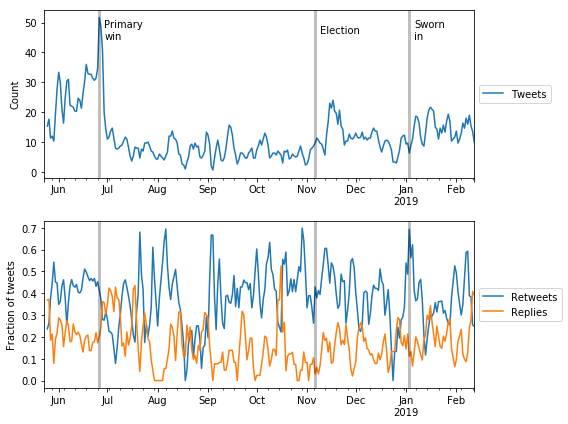

In [36]:
# Group by date and aggregate by number of tweets on that date
_s = df.groupby('date').agg({'id':len,'is_retweet':'sum','reply_id':lambda x:sum(x.notnull())})

# Reindex the data to be continuous over the range, fill in missing dates as 0s
_min_date, _max_date = _s.index.min(), _s.index.max()
_s = _s.reindex(pd.date_range(_min_date,_max_date),fill_value=0)
_s.columns = ['Tweets','Retweets','Replies']
_s_frac = _s[['Retweets','Replies']].div(_s['Tweets'],axis=0).fillna(0)

# Make the plot
f,axs = plt.subplots(2,1,figsize=(8,6))
_s['Tweets'].rolling(3).mean().plot(ax=axs[0])
_s_frac.rolling(3).mean().plot(ax=axs[1],legend=False)

axs[0].legend(loc='center left',bbox_to_anchor=(1,.5))
axs[1].legend(loc='center left',bbox_to_anchor=(1,.5))
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Fraction of tweets')

# Annotate the plot with lines corresponding to major events
for ax in axs:
    ax.axvline(pd.Timestamp('2018-06-26'),lw=3,c='k',alpha=.25) # Primary win
    ax.axvline(pd.Timestamp('2018-11-06'),lw=3,c='k',alpha=.25) # Election day
    ax.axvline(pd.Timestamp('2019-01-03'),lw=3,c='k',alpha=.25) # Swearing in
    
axs[0].annotate(xy=(pd.Timestamp('2018-06-26')+pd.Timedelta(3,'d'),47.5),s='Primary\nwin',va='center')
axs[0].annotate(xy=(pd.Timestamp('2018-11-06')+pd.Timedelta(3,'d'),47.5),s='Election',va='center')
axs[0].annotate(xy=(pd.Timestamp('2019-01-03')+pd.Timedelta(3,'d'),47.5),s='Sworn\nin',va='center')

f.tight_layout()
f.savefig('aoc_activity.png',dpi=300,bbox_inches='tight')

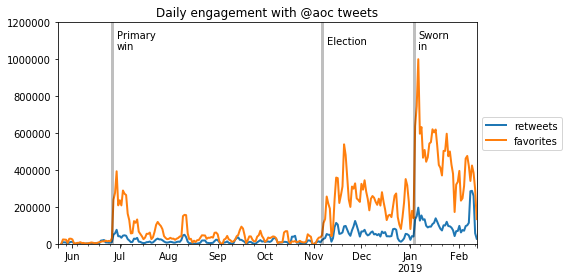

In [37]:
# Group by the date and aggregate by the sum of retweets and favorites for all tweets on that date
_s = df.groupby('date').agg({'retweets':'sum','favorites':'sum'})

# Reindex the data to be continuous over the range, fill in missing dates as 0s
_min_date, _max_date = _s.index.min(), _s.index.max()
_s = _s.reindex(pd.date_range(_min_date,_max_date),fill_value=0)

# Make the plot
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().plot(legend=False,lw=2,ax=ax)
ax.set_ylim((0,1200000))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_title('Daily engagement with @aoc tweets')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2018-06-26'),lw=3,c='k',alpha=.25) # Primary win
ax.axvline(pd.Timestamp('2018-11-06'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2019-01-03'),lw=3,c='k',alpha=.25) # Swearing in

ax.annotate(xy=(pd.Timestamp('2018-06-26')+pd.Timedelta(3,'d'),1100000),s='Primary\nwin',va='center')
ax.annotate(xy=(pd.Timestamp('2018-11-06')+pd.Timedelta(3,'d'),1100000),s='Election',va='center')
ax.annotate(xy=(pd.Timestamp('2019-01-03')+pd.Timedelta(3,'d'),1100000),s='Sworn\nin',va='center')

f.tight_layout()
f.savefig('aoc_engagement.png',dpi=300,bbox_inches='tight')

We can also do a bit of sentiment analysis. You'll likely need to [install the NLTK data](https://www.nltk.org/data.html) for this to work. We are going to use the [VADER sentiment analysis tool](https://github.com/cjhutto/vaderSentiment) that was specifically trained for social media text: [see paper here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf).

In [38]:
# Get sentiment scores for each tweet's text
df['sentiment'] = df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

Plot out the daily sentiment of tweets with major events annotated.

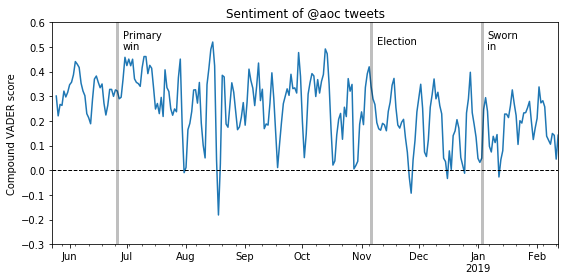

In [39]:
# Group by the date and aggregate by the average sentiment for all tweets on that date
_s = df.groupby('date').agg({'sentiment':'mean'})

# Reindex the data to be continuous over the range, fill in missing dates as 0s
_min_date, _max_date = _s.index.min(), _s.index.max()
_s = _s.reindex(pd.date_range(_min_date,_max_date),fill_value=0)

# Make the plot with a 7-day rolling average
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().plot(legend=False,ax=ax)
ax.set_ylim((-.3,.6))
ax.axhline(0,ls='--',c='k',lw=1)
ax.set_title('Sentiment of @aoc tweets')
ax.set_ylabel('Compound VADER score')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2018-06-26'),lw=3,c='k',alpha=.25) # Primary win
ax.axvline(pd.Timestamp('2018-11-06'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2019-01-03'),lw=3,c='k',alpha=.25) # Swearing in

ax.annotate(xy=(pd.Timestamp('2018-06-26')+pd.Timedelta(3,'d'),.525),s='Primary\nwin',va='center')
ax.annotate(xy=(pd.Timestamp('2018-11-06')+pd.Timedelta(3,'d'),.525),s='Election',va='center')
ax.annotate(xy=(pd.Timestamp('2019-01-03')+pd.Timedelta(3,'d'),.525),s='Sworn\nin',va='center')

f.tight_layout()
f.savefig('aoc_sentiment.png',dpi=300,bbox_inches='tight')

Compute the engagement for @AOC tweets, ignoring retweets and replies, and normalizing for total tweet activity on that day.

There are 1,336 tweets that are not retweets or replies.


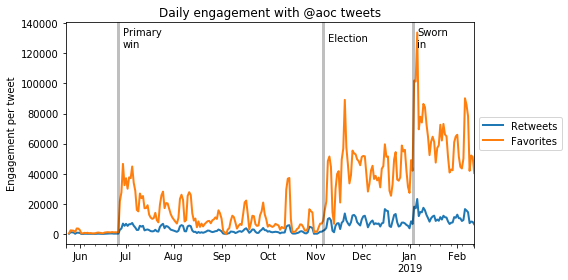

In [40]:
c1 = ~df['is_retweet']
c2 = df['reply_id'].isnull()

pure_tweets_df = df[c1 & c2]
print("There are {0:,} tweets that are not retweets or replies.".format(len(pure_tweets_df)))

_s = pure_tweets_df.groupby('date').agg({'retweets':'sum','favorites':'sum','id':len})
_s = _s[['retweets','favorites']].div(_s['id'],axis=0)
_s.columns = ['Retweets','Favorites']

# Reindex the data to be continuous over the range, fill in missing dates as 0s
_min_date, _max_date = _s.index.min(), _s.index.max()
_s = _s.reindex(pd.date_range(_min_date,_max_date),fill_value=0)

# Make the plot
f,ax = plt.subplots(1,1,figsize=(8,4))
ax = _s.rolling(3).mean().plot(legend=False,lw=2,ax=ax)
# ax.set_yscale('symlog')
# ax.set_ylim((1e1,1e6))

ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_title('Daily engagement with @aoc tweets')
ax.set_ylabel('Engagement per tweet')

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2018-06-26'),lw=3,c='k',alpha=.25) # Primary win
ax.axvline(pd.Timestamp('2018-11-06'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2019-01-03'),lw=3,c='k',alpha=.25) # Swearing in

ax.annotate(xy=(pd.Timestamp('2018-06-26')+pd.Timedelta(3,'d'),130000),s='Primary\nwin',va='center')
ax.annotate(xy=(pd.Timestamp('2018-11-06')+pd.Timedelta(3,'d'),130000),s='Election',va='center')
ax.annotate(xy=(pd.Timestamp('2019-01-03')+pd.Timedelta(3,'d'),130000),s='Sworn\nin',va='center')

f.tight_layout()
f.savefig('aoc_engagement_no_rt_reply.png',dpi=300,bbox_inches='tight')

Plot favorites per retweet.

Text(2019-01-06 00:00:00, 0.45, 'Sworn\nin')

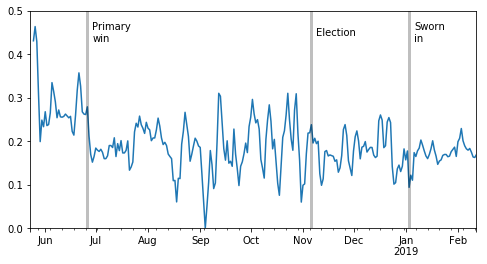

In [41]:
f,ax = plt.subplots(1,1,figsize=(8,4))

(_s['Retweets']/_s['Favorites']).fillna(0).rolling(3).mean().plot(ax=ax)

ax.set_ylim((0,.5))

# Annotate the plot with lines corresponding to major events
ax.axvline(pd.Timestamp('2018-06-26'),lw=3,c='k',alpha=.25) # Primary win
ax.axvline(pd.Timestamp('2018-11-06'),lw=3,c='k',alpha=.25) # Election day
ax.axvline(pd.Timestamp('2019-01-03'),lw=3,c='k',alpha=.25) # Swearing in

ax.annotate(xy=(pd.Timestamp('2018-06-26')+pd.Timedelta(3,'d'),.45),s='Primary\nwin',va='center')
ax.annotate(xy=(pd.Timestamp('2018-11-06')+pd.Timedelta(3,'d'),.45),s='Election',va='center')
ax.annotate(xy=(pd.Timestamp('2019-01-03')+pd.Timedelta(3,'d'),.45),s='Sworn\nin',va='center')

What are the top tweets by retweets per favorite? The're primarily from before her primary win.

In [42]:
df['rt_fav_ratio'] = (df['retweets']/df['favorites']).replace({np.inf:np.nan})
top_retweets = df['rt_fav_ratio'].dropna().sort_values(ascending=False).head(10)
df.loc[top_retweets.index,['created','text','retweets','favorites']]

,created,text,retweets,favorites
2775,2018-06-12 02:18:10+00:00,@BenjSilv @nycDSA It’s a remote team! People a...,5,3
3135,2018-05-26 19:58:24+00:00,"@itismikemcd People take this for granted, but...",82,79
3155,2018-05-25 20:43:50+00:00,"ICE has LOST 1,400 children that they had sepa...",2847,3175
2522,2018-06-20 19:24:23+00:00,"Labor unions @UFCW, @GoIUPAT, &amp; @RWDSU rep...",214,259
2544,2018-06-19 23:55:13+00:00,We're looking for bilingual (SP) volunteers re...,105,129
2650,2018-06-16 19:04:03+00:00,We're looking for volunteers registered to vot...,450,617
2527,2018-06-20 17:40:00+00:00,One horrific part about #FamilySeparation &amp...,586,882
2322,2018-06-26 11:45:17+00:00,Don't know where to go or how to help today?\n...,326,507
2493,2018-06-21 17:04:20+00:00,".@repjoecrowley’s #2 all-time career donor, Bl...",999,1556
2941,2018-06-05 16:48:21+00:00,"Surprise, surprise: last-minute pollsite chang...",633,1018


Is there an intereseting relationship between seniment and retweet/favorite ratio? We can specify a simple univariate LOESS regression for the relationship between sentiment and the retweet-per-favorite ratio. It appears that extremely negative and positive tweets have higher ratios than neutral tweets.

(0, 1)

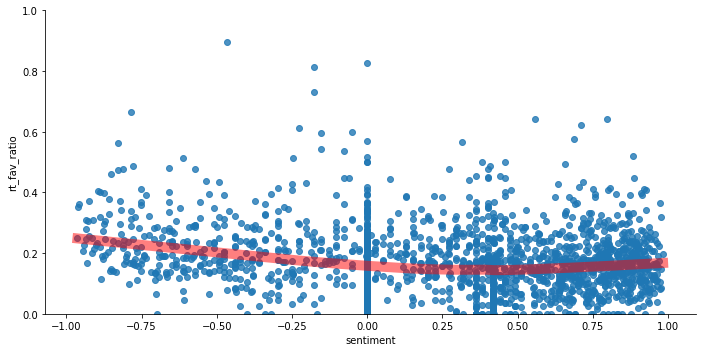

In [43]:
g = sb.lmplot(x='sentiment',y='rt_fav_ratio',data=df,lowess=True,aspect=2,
              line_kws={'color':'red','linewidth':10,'alpha':.5})
ax = g.axes[0,0]
ax.set_ylim((0,1))

## Pulling a user's friends

In the parlance of the Twitter API, the people who follow an account are "followers" and the people followed by an account are "friends". There's unfortuantely no timestamp meta-data about when friend and follower relationships were created. The API limits on this are much more stringent than other API calls: only 200 accounts per request and only 15 requests per 15-minute window: basically 200 accounts per minute or 3,000 accounts before you hit the rate limit. AOC has 1,417 friends, so it takes 8 API requests to get them all, leaving me with 7 requests in this 15-minute window.

In [44]:
aoc_friends = api.GetFriends(screen_name='aoc',count=200,skip_status=True)
print("There are {0:,} friends.".format(len(aoc_friends)))

There are 1,420 friends.


We can check my API rate limit status too.

In [45]:
api.rate_limit.resources

{'users': {'/users/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1549988882}},
 'statuses': {'/statuses/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1549988885},
  '/statuses/user_timeline': {'limit': 900,
   'remaining': 881,
   'reset': 1549988916}},
 'friends': {'/friends/list': {'limit': 15,
   'remaining': 7,
   'reset': 1549989000}}}

More specifically:

In [46]:
api.rate_limit.resources['friends']['/friends/list']['remaining']

7

This resets at:

In [47]:
datetime.fromtimestamp(api.rate_limit.resources['friends']['/friends/list']['reset']).strftime('%H:%M:%S')

'09:30:00'

I think "friends" convey much more valuable information about an account than followers, primarily because an account doesn't choose who follows them. However, if you wanted to get the followers of an account, we use the `GetFollowers` method. I'm only going to grab 200 so I don't burn more API calls.

In [48]:
aoc_followers = api.GetFollowers(screen_name='aoc',skip_status=True,total_count=200)

We can access these user objects to pull out interesting meta-data.

In [49]:
aoc_friends[0].name

'Rhiana Gunn-Wright'

In [50]:
aoc_friends[0].description

'Policy lead for the #GreenNewDeal @newconsensus, former Policy Director for @AbdulElSayed. tweets/opinions are my own.'

In [51]:
aoc_friends[0].screen_name

'rgunns'

In [52]:
aoc_friends[0].created_at

'Wed Mar 04 00:52:57 +0000 2009'

In [53]:
aoc_friends[0].statuses_count

1312

In [54]:
aoc_friends[0].followers_count

4117

In [55]:
aoc_friends[0].friends_count

296

In [56]:
aoc_friends[0].verified

False

In [57]:
aoc_friends[0].id

22709207

Loop through all the friends of @aoc and turn it into a DataFrame.

In [58]:
aoc_friend_payloads = []

for friend in aoc_friends:
    p = {}
    p['name'] = friend.name
    p['description'] = friend.description
    p['screen_name'] = friend.screen_name
    p['created_at'] = friend.created_at
    p['statuses_count'] = friend.statuses_count
    p['followers_count'] = friend.followers_count
    p['friends_count'] = friend.friends_count
    p['verified'] = friend.verified
    p['id'] = friend.id
    aoc_friend_payloads.append(p)
    
aoc_friend_df = pd.DataFrame(aoc_friend_payloads)
aoc_friend_df['created_at'] = pd.to_datetime(aoc_friend_df['created_at'])
aoc_friend_df['created_at'] = aoc_friend_df['created_at'].dt.tz_convert(None)
aoc_friend_df['account_age'] = aoc_friend_df['created_at'].apply(lambda x:(datetime.now() - x)/pd.Timedelta(1,'d'))
aoc_friend_df.head()

,created_at,description,followers_count,friends_count,id,name,screen_name,statuses_count,verified,account_age
0,2009-03-04 00:52:57,Policy lead for the #GreenNewDeal @newconsensu...,4117,296,22709207,Rhiana Gunn-Wright,rgunns,1312,False,3632.348974
1,2019-01-03 15:51:05,Cultivating the next generation of leaders and...,2455,209,1080854064567668736,Movement School,mvmtschool,97,False,39.725270
2,2016-12-08 17:00:41,Proudly serving MD's 8th District. Member of: ...,48641,4585,806906355214852096,Rep. Jamie Raskin,RepRaskin,5408,True,795.676937
3,2018-12-31 18:12:28,Proudly representing Massachusetts' 3rd Congre...,5289,431,1079802482640019456,Congresswoman Lori Trahan,RepLoriTrahan,269,True,42.627087
4,2016-03-25 04:13:46,Liberty Flows from the FrontLine.,17397,3745,713217283246530560,Chase Iron Eyes,ChaseIronEyes,2556,True,1054.209518


In this sample of Twitter accounts, are there any interesting trends in verified accounts?

/Users/briankeegan/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


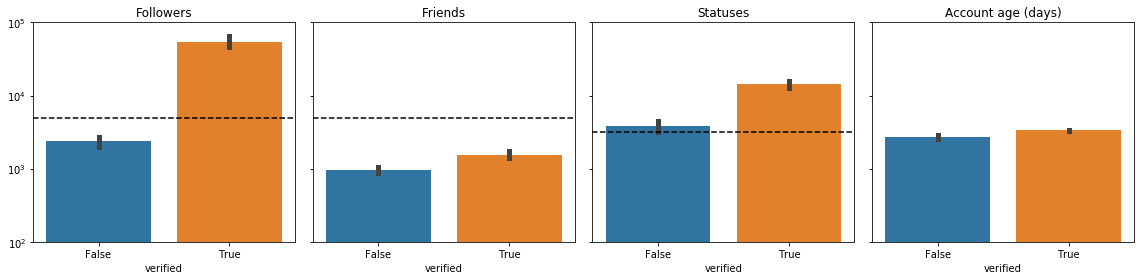

In [59]:
f,axs = plt.subplots(1,4,figsize=(16,4),sharey=True)

sb.barplot(x='verified',y='followers_count',data=aoc_friend_df,ax=axs[0],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='friends_count',data=aoc_friend_df,ax=axs[1],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='statuses_count',data=aoc_friend_df,ax=axs[2],estimator=np.median,errwidth=5)
sb.barplot(x='verified',y='account_age',data=aoc_friend_df,ax=axs[3],estimator=np.median,errwidth=5)

axs[0].set_title('Followers')
axs[1].set_title('Friends')
axs[2].set_title('Statuses')
axs[3].set_title('Account age (days)')

# As we'll see below, having more than 5,000 friends could complicate our sampling
axs[0].axhline(5000,ls='--',c='k')
axs[1].axhline(5000,ls='--',c='k')
axs[2].axhline(3200,ls='--',c='k')

for ax in axs:
    ax.set_ylim((1e2,1e5))
    ax.set_yscale('symlog')
    ax.set_ylabel(None)

f.tight_layout()

Are these differences statistically-significant? Let's run some [t-tests](https://en.wikipedia.org/wiki/T-test).

In [60]:
from scipy import stats

for var in ['followers_count','friends_count','statuses_count','account_age']:
    vals1 = aoc_friend_df.loc[aoc_friend_df['verified'] == True,var]
    vals2 = aoc_friend_df.loc[aoc_friend_df['verified'] == False,var]
    test,pvalue = stats.ttest_ind(vals1,vals2)
    str_fmt = "The differences in {0}: t = {1:.2f} \t p={2:.3f}"
    print(str_fmt.format(var,test,pvalue))

The differences in followers_count: t = 4.98 	 p=0.000
The differences in friends_count: t = 2.05 	 p=0.041
The differences in statuses_count: t = 8.88 	 p=0.000
The differences in account_age: t = 10.62 	 p=0.000


Or use the non-parametric [Mann-Whitney U-test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) since our data is so skewed.

In [61]:
for var in ['followers_count','friends_count','statuses_count','account_age']:
    vals1 = aoc_friend_df.loc[aoc_friend_df['verified'] == True,var]
    vals2 = aoc_friend_df.loc[aoc_friend_df['verified'] == False,var]
    test,pvalue = stats.mannwhitneyu(vals1,vals2)
    str_fmt = "The differences in {0}: U = {1:,.0f} \t p = {2:,.3f}"
    print(str_fmt.format(var,test,pvalue))

The differences in followers_count: U = 54,648 	 p = 0.000
The differences in friends_count: U = 182,520 	 p = 0.000
The differences in statuses_count: U = 139,068 	 p = 0.000
The differences in account_age: U = 171,274 	 p = 0.000


Unsurprisingly, verified accounts have more followers and are older than non-verified accounts. But they also appear to be more active and have more friends.

### Ego-network
We can make a 1.5-step ego-network of the accounts @aoc follows and the accounts each of them follow. Using the `GetFriends` is too "expensive" because it cost us 8 API calls to get a single account's followers since it only returns 200 accounts at a time. Twitter also exposes a [get friends/ids](https://developer.twitter.com/en/docs/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) end-point that will return up to 5,000 user IDs per request. The number of requests remains 15 requests per 15-minute window, but we can now get the friend networks for 15 accounts per 15 minutes rather than maybe only 1 or 2. The challenge with this is that we will need to "rehydrate" these user IDs at some point.

Here, we'll use the "total_count" parameter to limit it to 5,000 accounts in case one of these accounts follows thousands of accounts. 

Store the data in a dictionary keyed by account name and with the list of user IDs integers as values. Initialize with @aoc.

In [62]:
aoc_friends_d = {'aoc':api.GetFriendIDs(screen_name='aoc',total_count=5000,count=5000)}

Check there's still something like 1,400 for "aoc".

In [63]:
len(aoc_friends_d['aoc'])

1420

How many accounts have more than 5000 friends? So about 10% of our network will be incomplete if we limit to only a single "page" of 5,000 user IDs per follower.

In [64]:
gt5000_aoc_friend_df = aoc_friend_df[aoc_friend_df['friends_count'] > 5000]
len(gt5000_aoc_friend_df)

148

Who are some of these high-friend accounts? Even at 5,000 friends per request, it will still cost you 123 API requests (and thus 123 minutes) to get Barack Obama's 615,000 friends.

In [65]:
subset_cols = ['name','screen_name','friends_count','followers_count','description']
gt5000_aoc_friend_df.sort_values('friends_count',ascending=False).head(10)[subset_cols]

,name,screen_name,friends_count,followers_count,description
1293,Taye Diggs,TayeDiggs,661689,639629,I'm serious chocolate and don't get it twisted...
1223,Barack Obama,BarackObama,615863,104575605,"Dad, husband, President, citizen."
976,Soledad O'Brien,soledadobrien,453876,933309,"Thank you, next."
408,Twitter Verified,verified,314948,2608255,Twitter is working on a new authentication and...
107,Cory Booker,CoryBooker,92846,4168355,U.S. senator from New Jersey and Democratic ca...
1167,Millennial Politics,MillenPolitics,92659,111133,"Shining a spotlight on progressive candidates,..."
1166,Nathan H. Rubin,NathanHRubin,73669,79276,"Founder, @MillenPolitics. Young Leaders Board,..."
1246,NPR,NPR,71252,7673087,News. Arts & Life. Music. Everything and more ...
724,Elianne Ramos,ergeekgoddess,69125,54220,Hopelessly Undomestic | Speaker | Public Affai...
913,PBS,PBS,51185,2253006,PBS invites you to discover new ideas and expl...


This loop will go through the list of `aoc_friends` (a list of `User` objects) and then get the 5,000 friends' user IDs for each of them. With these rate limits of 15 requests per 15 min, it will take 1417 minutes (23.6 hours) to get our sample of data for AOC's 1,417 friends. You can now start to see the appeal of parallelizing requests!

You probably don't want to run this loop.

Instead, I've done this scraping for you and saved the results in a JSON file.

In [116]:
with open('aoc_friend_ids2.json','r') as f:
    aoc_friends_d = json.load(f)

Now we want to make a network of who follows whom.

In [186]:
friends_l = []

# Turn the dictionary into an edgelist
for user_id, friend_ids in aoc_friends_d.items():
    for friend_id in friend_ids:
        friends_l.append((str(user_id),str(friend_id)))
        
# Turn the list of dictionaries into a DataFrame
friends_df = pd.DataFrame(friends_l,columns=['user_id','friend_id'])

# Get the unique user_ids for AOC's friends
unique_friend_ids = friends_df['user_id'].unique()

# Just keep friends of AOC in the list
# Throw away friends of friends who aren't direct friends of AOC
subset_friends_df = friends_df[friends_df['friend_id'].isin(unique_friend_ids)]

# Print out number of edges remaining
print('Edges before: {:,}'.format(len(friends_df)),'\nEdges after: {:,}'.format(len(subset_friends_df)))

Edges before: 2,573,446 
Edges after: 160,041


Map the numeric user_id back to screen_name.

In [ ]:
ids_to_screen_name_map = {str(user.id):user.screen_name for user in aoc_friends}
ids_to_screen_name_map['138203134'] = 'aoc'

Building on the [shared audience measure](http://faculty.washington.edu/kstarbi/Stewart_Starbird_Drawing_the_Lines_of_Contention-final.pdf) used by Stewart, *et al.* (2017), I computed [Jaccard coefficients](https://en.wikipedia.org/wiki/Jaccard_index) for the friend sets of each account. The intuituion here is that if two accounts are friends with all the same accounts, their score would be 1 while if two accounts had no friends in common, their score would be 0. This has the benefit of giving us a numerical weight to otherwise binary friend relationships: friend relations are "stronger" if they are more strongly embedded in a network with other overlapping friend relations and "weaker" if there is less overlap. This requires pair-wise evaluations of $1420*1419=2,014,980$ combinations, which takes about 20 minutes on my computer.

I've saved you the time and you can read in these pairwise Jaccard similarities from disk.

In [193]:
friend_jaccard_df = pd.read_csv('aoc_all_friend_jaccard.csv',index_col=0,
                                dtype={'user':str,'friend':str,'jaccard':float})

friend_jaccard_df.head()

,user,friend,jaccard
0,138203134,1080854064567668736,0.059829
1,138203134,806906355214852096,0.048734
2,138203134,1079802482640019456,0.049516
3,138203134,713217283246530560,0.020949
4,138203134,78706973,0.028120


We can combine the `subset_friends_df` with `friend_jaccard_df` using pandas's [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) command.

In [196]:
# Left-join the subset_friends and friend_jaccard DataFrames
friend_el = pd.merge(subset_friends_df,
                     friend_jaccard_df,
                     left_on=['user_id','friend_id'],
                     right_on=['user','friend'],how='left')

# Keep a few columns
friend_el = friend_el[['user','friend','jaccard']]

# Map the user_ids back to screen_names
friend_el['user'] = friend_el['user'].apply(str).map(ids_to_screen_name_map)
friend_el['friend'] = friend_el['friend'].apply(str).map(ids_to_screen_name_map)

# Save to disk
friend_el.to_csv('aoc_friends_edgelist.csv')

# Inspect
friend_el.tail()

,user,friend,jaccard
160036,DeanElmore,jsmooth995,0.006267
160037,DeanElmore,xeni,0.004169
160038,DeanElmore,lessig,0.005323
160039,DeanElmore,alex11shuck,0.058063
160040,DeanElmore,TEDTalks,0.011236


We are going to use the [`networkx`](https://networkx.github.io/documentation/stable/) (that should come with Anaconda by default) to convert this edgelist into a Graph object.

In [197]:
# Import networkx
import networkx as nx

This raw network is very dense: there are about 100 times more edges than nodes. A general heuristic for graph visualization is you want the number of nodes and edges to be about the same order of magnitude to prevent [overplotting](https://www.displayr.com/what-is-overplotting/).

In [201]:
g_dense = nx.from_pandas_edgelist(friend_el,source='user',target='friend',create_using=nx.Graph)
print("There are {0:,} nodes and {1:,} edges.".format(g_dense.number_of_nodes(),g_dense.number_of_edges()))

There are 1,387 nodes and 130,580 edges.


The distribution of Jaccard scores we computed is very skewed. We can now use these similarity scores to filter out "weaker" edges. We are effectively throwing away all of the data to the left of the dashed line at the 95% percentile to help us with visualization.

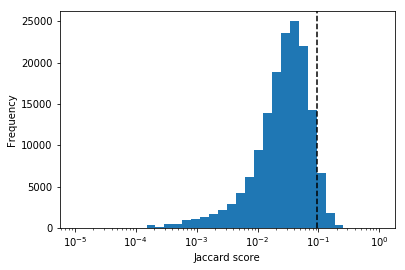

In [210]:
ax = friend_el['jaccard'].plot(kind='hist',bins=np.logspace(-5,0,35))
ax.set_xscale('log')
ax.set_xlabel('Jaccard score')
ax.axvline(np.percentile(friend_el['jaccard'],95),c='k',ls='--')

Keep only the top 5% of edges for visualization purposes.

In [202]:
# Keep only the top 5% of edges by Jaccard coefficients
top_friend_el = friend_el[friend_el['jaccard'] > np.percentile(friend_el['jaccard'],95)]

# Write these top edges into the network
g = nx.from_pandas_edgelist(top_friend_el,source='user',target='friend',edge_attr=True,create_using=nx.Graph)
print("There are {0:,} nodes and {1:} edges.".format(g.number_of_nodes(),g.number_of_edges()))

# Save to disk
nx.write_gexf(g,'aoc_friends_filtered.gexf')

There are 726 nodes and 4753 edges.


I visualized the network below in [Gephi](https://gephi.org/). We see a distinctive community structure reflecting different identities like local organizations, journalists, national politicians, activist groups, *etc*.

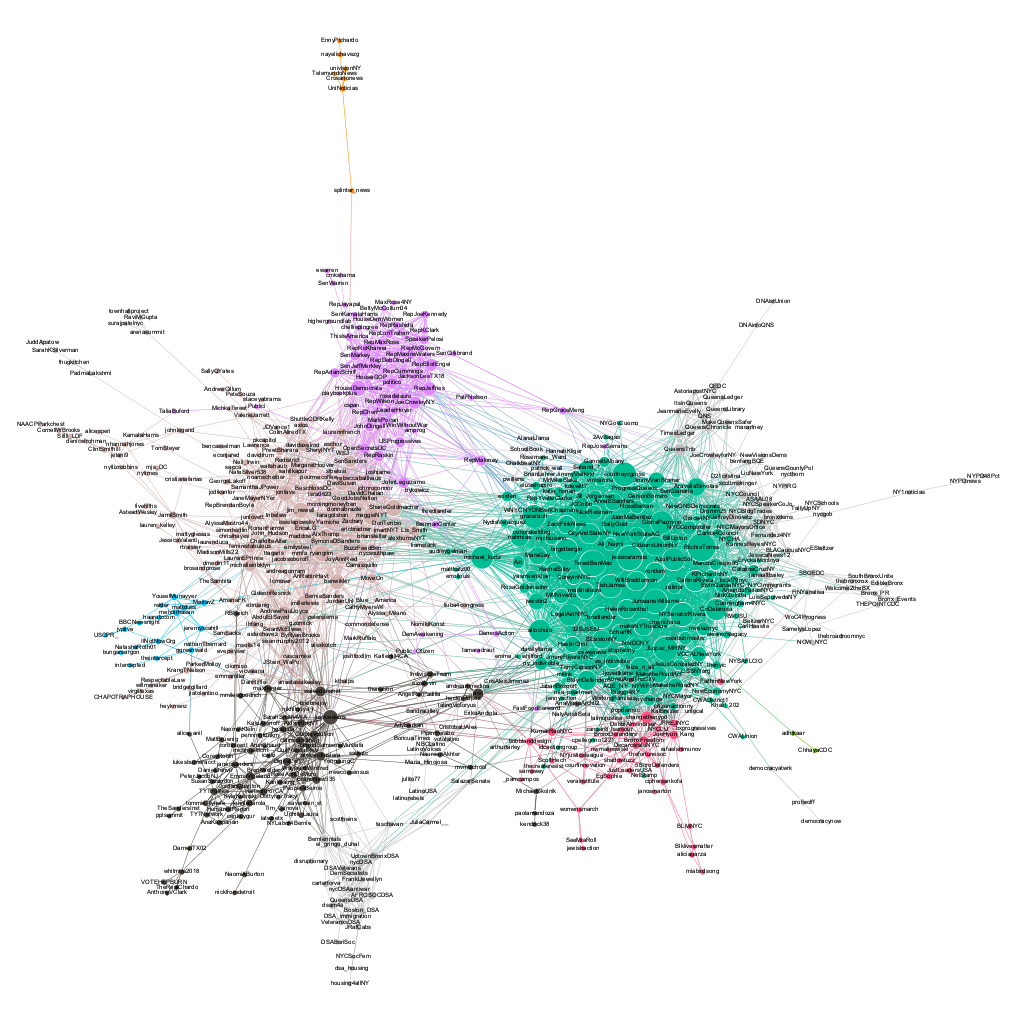

In [208]:
from IPython.display import Image

Image('aoc_friends_filtered.png')

## Using the streaming API

We can also sit on Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/sample-realtime/api-reference/get-statuses-sample) and get a sample of tweets that are produced in real time. The `.GetStreamSample()` method returns a [generator](https://wiki.python.org/moin/Generators), which is an advanced type of object that doesn't store any data *per se* but points to successive locations where you can find data. In this case, the generator points to where we can find the next tweet in the sample. For 10,000 tweets on a stream sampling approximately 1% of live tweets, this may take 2–3 minutes.

In [230]:
# Make the generator
stream = api.GetStreamSample()

# Make an empty list to store the tweet statuses
stream_list = []

# Start iterating through the stream
for status in stream:
    
    # As long as we have fewer than this many tweets
    if len(stream_list) < 10000:
        
        # And if it's not a delete status request
        if 'delete' not in status:
        
            # Add another tweet to our list
            stream_list.append(status)
        
    # Otherwise stop
    else:
        break
        
"There are {0:,} tweets from the stream.".format(len(stream_list))

'There are 10,000 tweets from the stream.'

Look at one of our statuses.

In [231]:
stream_list[0]

{'created_at': 'Sun Feb 10 01:45:18 +0000 2019',
 'id': 1094411958109974529,
 'id_str': '1094411958109974529',
 'text': '求めてない方向に行かれると萎えざるをえない',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1036620562494193665,
  'id_str': '1036620562494193665',
  'name': '岡八郎',
  'screen_name': 'chack_nico',
  'location': '関西',
  'url': None,
  'description': '関西で医療系のことしてます！20半ばの男です😂 44ch📺 & ¥540🍝🇮🇹会員です！高槻は6年過ごした第2の故郷です🐙',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 40,
  'friends_count': 63,
  'listed_count': 1,
  'favourites_count': 698,
  'statuses_count': 562,
  'created_at': 'Mon Sep 03 14:22:56 +0000 2018',
  'utc_offset': None,
  'time_zone': None,
  'geo_enabled': False,
  'lang': 'ja',
  'contr

Because these dictionaries represent raw JSON rather than cute `Status` objects, we need to adapt our loop from above that turns tweet statuses into a flat DataFrame. (I warned you!)

In [64]:
def tweet_cleaner(status):
    payload = {}
    payload['screen_name'] = status['user']['screen_name']
    payload['created'] = pd.to_datetime(status['created_at'])
    payload['retweets'] = status['retweet_count']
    payload['favorites'] = status['favorite_count']
    payload['id'] = status['id']
    payload['reply_screen_name'] = status['in_reply_to_screen_name']
    payload['reply_id'] = status['in_reply_to_status_id']
    payload['source'] = BeautifulSoup(status['source']).text
    payload['lang'] = status['lang']
    
    if status['place']:
        payload['place'] = status['place']['country']
    else:
        payload['place'] = None

    if len(status['entities']['user_mentions']) > 0:
        payload['user_mentions'] = '; '.join([m['screen_name'] for m in status['entities']['user_mentions']])
    else:
        payload['user_mentions'] = None

    if len(status['entities']['hashtags']) > 0:
        payload['hashtags'] = '; '.join([h['text'] for h in status['entities']['hashtags']])
    else:
        payload['hashtags'] = None

    # If an account retweets another account, we should store that information
    if 'retweeted_status' in status:
        rt_status = status['retweeted_status']
        if 'extended_tweet' in rt_status:
            payload['text'] = rt_status['extended_tweet']['full_text']
            if len(rt_status['extended_tweet']['entities']['hashtags']) > 0:
                payload['hashtags'] = '; '.join([h['text'] for h in rt_status['extended_tweet']['entities']['hashtags']])
            else:
                payload['hashtags'] = None
        else:
            try:
                payload['text'] = rt_status['text']
            except:
                payload['text'] = rt_status['full_text']
            if len(rt_status['entities']['hashtags']) > 0:
                payload['hashtags'] = '; '.join([h['text'] for h in rt_status['entities']['hashtags']])
            else:
                payload['hashtags'] = None
        payload['is_retweet'] = True
        payload['retweeted_screen_name'] = rt_status['user']['screen_name']
        payload['retweeted_created'] = rt_status['created_at']
        payload['retweeted_source'] = BeautifulSoup(rt_status['source']).text
        
    else:
        if status['truncated']:
            payload['text'] = status['extended_tweet']['full_text']
        else:
            try:
                payload['text'] = status['text']
            except:
                payload['text'] = status['full_text']
        payload['is_retweet'] = False
        payload['retweeted_screen_name'] = False
        payload['retweeted_created'] = False
        payload['retweeted_source'] = False

    return payload

Loop through our list of dictionaries (including the delete stream objects) and flatten the dictionaries out into something we can read into a DataFrame. Include some exception handling that will keep track of which tweets throw errors and prints out the first 50 of those tweet's index position in the `stream_list` for us to diagnose.

In [242]:
stream_statuses_flat = []
errors = []

for i,status in enumerate(stream_list):
    try:
        payload = tweet_cleaner(status)
        stream_statuses_flat.append(payload)
    except:
        errors.append(str(i))

if len(errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(errors[:50]))

There were no errors!


Make our DataFrame, clean up some columns, and make some new ones.

In [243]:
stream_df = pd.DataFrame(stream_statuses_flat)
stream_df['created'] = pd.to_datetime(stream_df['created'])
stream_df['created'] = stream_df['created'].dt.tz_convert(None)
stream_df.tail()

,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
9995,2019-02-10 01:49:40,0,None,1094413057034350592,True,in,None,NaN,None,Sun Feb 10 01:45:10 +0000 2019,RPAutoBase,Auto Base RP,0,docnghan,Twitter for iPhone,"RPA Followan sama gua rt, mau dm/ fambest rep ...",RPAutoBase
9996,2019-02-10 01:49:40,0,DAPUMP,1094413057009143808,True,ja,None,NaN,None,Sat Feb 09 23:58:55 +0000 2019,We_Love_DPC,Twitter for iPhone,0,SundayBake,Twitter for Android,CDTVにて\nDA PUMPと一緒にお祝いしたい人募集中！\n#DAPUMP\nhttps...,We_Love_DPC
9997,2019-02-10 01:49:40,0,None,1094413057030160389,True,es,None,NaN,None,Sat Feb 09 19:24:37 +0000 2019,SaturnBiAndrome,Twitter Web Client,0,clv1980,Twitter for iPhone,@JuliantinaFans Para las que no saben que es W...,SaturnBiAndrome; JuliantinaFans
9998,2019-02-10 01:49:40,0,None,1094413057038508032,False,ja,None,NaN,None,False,False,False,0,chachababy427,Twitter for iPhone,私高校一年生の時に階段から落ちて\n犬が階段登らないようにしてたサークルにお股ぶつけて\n股...,None
9999,2019-02-10 01:49:40,0,None,1094413057034465281,True,en,None,NaN,None,Sat Feb 09 16:08:36 +0000 2019,GuguNdabezitha,Twitter for iPhone,0,ntsako_nunuzz,Twitter for Android,"Nigerian girls have the best edges, weaves, sk...",GuguNdabezitha


Where are people writing their tweets in this sample?

In [235]:
stream_df['source'].value_counts().head(10)

Twitter for iPhone     4010
Twitter for Android    3998
Twitter Web Client      598
Twitter Web App         372
twittbot.net            212
Twitter for iPad        147
Facebook                 98
TweetDeck                58
تطبيق قرآني              48
Zapier.com               29
Name: source, dtype: int64

What languages are these tweets in?

In [244]:
stream_df['lang'].value_counts().head(10)

en     3210
ja     2158
es      981
pt      837
und     737
ko      476
th      463
ar      285
in      274
tl      136
Name: lang, dtype: int64

If a tweet is geolocated, where is it?

In [245]:
stream_df['place'].value_counts().head(10)

United States                  63
Brasil                         21
日本                              8
Argentina                       7
Indonesia                       6
Republic of the Philippines     5
México                          4
Japan                           4
Chile                           3
Kingdom of Saudi Arabia         2
Name: place, dtype: int64

How many tweets are retweets?

In [236]:
stream_df['is_retweet'].value_counts()

True     5319
False    4681
Name: is_retweet, dtype: int64

How many tweets are replies?

In [238]:
stream_df['reply_id'].notnull().value_counts()

False    8024
True     1976
Name: reply_id, dtype: int64

Which users are getting a lot of retweets right now?

In [246]:
stream_df['retweeted_screen_name'].value_counts().head(10)

False              4681
BTS_twt              24
gsc_kahotan          22
RVsmtown             17
realDonaldTrump      15
amiamihobbynews      12
thejeffbosley         9
orangerouge_pr        8
karatkyung            8
FREEing_figure0       7
Name: retweeted_screen_name, dtype: int64

### Filtered streams

We can also filter the tweets in the stream. Here we only get tweets mentioning "Trump" and that have been auto-classified as written in English.

In [6]:
time.time()

1549814732.605301

In [8]:
# Make the generator
filtered_stream = api.GetStreamFilter(track=['Trump'],languages=['en'])

# Make an empty list to store the tweet statuses
filtered_stream_list = []

# What time did we start?
start = time.time()

# Start iterating through the stream
for status in filtered_stream:
    
    # As long as we have fewer than this many tweets
    if len(filtered_stream_list) < 1000:
        
        # And if it's not a delete status request
        if 'delete' not in status:
        
            # Add another tweet to our list
            filtered_stream_list.append(status)
        
    # Otherwise stop
    else:
        break

# What time did we stop?
stop = time.time()
elapsed = stop - start

"There are {0:,} tweets from the stream after {1:.0f} seconds.".format(len(filtered_stream_list),elapsed)

'There are 1,000 tweets from the stream after 44 seconds.'

Clean this up into a DataFrame.

In [9]:
filtered_stream_statuses_flat = []
filtered_errors = []

for i,status in enumerate(filtered_stream_list):
    try:
        payload = tweet_cleaner(status)
        filtered_stream_statuses_flat.append(payload)
    except:
        filtered_errors.append(str(i))

if len(filtered_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(filtered_errors[:50]))
    
filtered_stream_df = pd.DataFrame(filtered_stream_statuses_flat)
filtered_stream_df['created'] = pd.to_datetime(filtered_stream_df['created'])
filtered_stream_df['created'] = filtered_stream_df['created'].dt.tz_convert(None)
filtered_stream_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
995,2019-02-10 16:08:48,0,None,1094629264140439553,True,en,None,NaN,None,Sun Feb 10 14:28:38 +0000 2019,GeorgeTakei,Twitter for iPhone,0,InfojunkyCole,Twitter for Android,Talks on Trump’s “border crisis” funding have ...,GeorgeTakei
996,2019-02-10 16:08:48,0,None,1094629264140521472,True,en,None,NaN,None,Thu Feb 07 21:05:53 +0000 2019,bbusa617,Twitter for Android,0,USAFOREVER2016,Twitter for Android,Ocasio-Cortez Literally CRIES Over Trump And I...,bbusa617
997,2019-02-10 16:08:48,0,None,1094629264274669568,True,en,None,NaN,None,Wed Feb 06 20:11:21 +0000 2019,JDScholten,Twitter for iPhone,0,DylanHunt2017,Twitter for Android,“Average farm income has fallen to near 15-yea...,JDScholten; ChuckGrassley; joniernst; SteveKingIA
998,2019-02-10 16:08:48,0,None,1094629264278806530,True,en,None,NaN,None,Sat Feb 09 16:28:29 +0000 2019,RepAdamSchiff,Twitter for iPhone,0,jamesG87776821,Twitter for iPhone,All countries do psychological profiles of oth...,RepAdamSchiff
999,2019-02-10 16:08:48,0,None,1094629264018808832,False,en,None,1.094628e+18,mkraju,False,False,False,0,mz_type,Twitter Web Client,@mkraju that's because @replizchaney doesn't g...,mkraju


Let's measure the sentiment of the tweets in this filtered s ample and plot the distribution of their sentiment values.

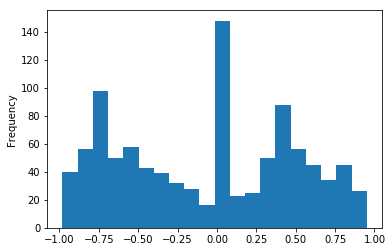

In [13]:
# Compute the sentiment scores
filtered_stream_df['sentiment'] = filtered_stream_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

# Plot the distribution
filtered_stream_df['sentiment'].plot(kind='hist',bins=20)

How many retweets in this sample?

In [14]:
filtered_stream_df['is_retweet'].value_counts()

True     755
False    245
Name: is_retweet, dtype: int64

Given the higher fraction of retweets, who is being retweeted?

In [15]:
filtered_stream_df['retweeted_screen_name'].value_counts().head(10)

False              245
realDonaldTrump     33
EdKrassen           28
BillKristol         18
kylegriffin1        17
RevDrBarber         10
neeratanden          9
adamdavidson         8
peterdaou            7
KTHopkins            7
Name: retweeted_screen_name, dtype: int64

## Search API

Twitter's [search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets) provides an endpoint to search for tweets matching a query for terms, accounts, hashtags, language, locations, and date ranges. This API endpoint has a rate limit of 180 requests per 15-minute window with 100 statuses per request: or 18,000 statuses per window or 72,000 statuses per hour.

You can explore some of the search functionality through Twitter's [advanced search interface](https://twitter.com/search-advanced). Note that the [standard search API](https://developer.twitter.com/en/docs/tweets/search/overview/standard) only provides a limited access to sample of tweets in the past 7 days, you'll need to pay more to access [historical APIs](https://developer.twitter.com/en/docs/tutorials/choosing-historical-api.html).

In [83]:
api.rate_limit.resources

{'search': {'/search/tweets': {'limit': 180,
   'remaining': 173,
   'reset': 1549819322}},
 'users': {'/users/show/:id': {'limit': 900,
   'remaining': 899,
   'reset': 1549816642}}}

In [51]:
query = api.GetSearch(term='aoc',count=100,lang='en',result_type='recent',return_json=True)

Loop through these 100 tweets.

In [66]:
search_statuses_flat = []
search_errors = []

for i,status in enumerate(query['statuses']):
    try:
        payload = tweet_cleaner(status)
        search_statuses_flat.append(payload)
    except:
        search_errors.append(str(i))

if len(search_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(search_errors[:50]))
    
search_df = pd.DataFrame(search_statuses_flat)
# search_df['created'] = pd.to_datetime(search_df['created'])
# search_df['created'] = search_df['created'].dt.tz_convert(None)
search_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
95,2019-02-10 16:38:12+00:00,0,None,1094636664440250368,False,en,None,1.094262e+18,bart_io,False,False,False,0,JustinaSalvati1,Twitter for iPhone,@bart_io @Vivianibarra @GuidoLupaz @RJRHSimmon...,bart_io; Vivianibarra; GuidoLupaz; RJRHSimmons...
96,2019-02-10 16:38:12+00:00,0,None,1094636663958110217,False,en,None,1.094636e+18,ChrisGTwoAgain,False,False,False,0,drj21h,Twitter Web App,"@ChrisGTwoAgain @ndrew_lawrence LOL, oh come o...",ChrisGTwoAgain; ndrew_lawrence
97,2019-02-10 16:38:12+00:00,0,None,1094636663777574912,True,en,None,NaN,None,Sun Feb 10 16:31:58 +0000 2019,DiamondandSilk,Twitter Web Client,286,ed_scheid,Twitter for iPhone,Netflix just bought @AOC Documentary for10M Do...,DiamondandSilk; AOC
98,2019-02-10 16:38:12+00:00,0,None,1094636663282708480,False,en,None,1.094439e+18,creewarrior7,False,False,False,0,sheilswe,Twitter for iPhone,@creewarrior7 @AOC I like her ideas and her re...,creewarrior7; AOC
99,2019-02-10 16:38:12+00:00,0,None,1094636662959808514,True,en,None,NaN,None,Sat Feb 09 20:14:07 +0000 2019,Timcast,Twitter for Android,2545,abovewater2,Twitter Web Client,This is getting scary.\n\nAOC and others are s...,Timcast


Write a loop to try to get more tweets. The `query` dictionary includes a sub-dictionary under the "search_metadata" key that includes information about paginating to find the next set of results.

In [211]:
search_tweets = []

while True:
    # When to stop?
    if len(search_tweets) == 2500:
        break
    
    # Get the first set of tweets
    if len(search_tweets) == 0:
        query = api.GetSearch(term='aoc',count=100,lang='en',result_type='recent',return_json=True)
        search_tweets += query['statuses']
        
    # Keep getting tweets
    else:
        # Find the last tweet to use as a max_id
        max_id = search_tweets[-1]['id']
        
        # Get the next set of tweets
        query = api.GetSearch(term='aoc',count=100,lang='en',return_json=True,max_id=max_id - 1)
        
        # Add them to the list of tweets
        search_tweets += query['statuses']
        
print("There are {0:,} tweets in the collection.".format(len(search_tweets)))

There are 2,500 tweets in the collection.


In [212]:
search_statuses_flat = []
search_errors = []

for i,status in enumerate(search_tweets):
    try:
        payload = tweet_cleaner(status)
        search_statuses_flat.append(payload)
    except:
        search_errors.append(str(i))

if len(search_errors) == 0:
    print("There were no errors!")
else:
    print("There were errors at the following indices:", '; '.join(search_errors[:50]))
    
search_df = pd.DataFrame(search_statuses_flat)
search_df['created'] = pd.to_datetime(search_df['created'])
search_df['created'] = search_df['created'].dt.tz_convert(None)
search_df.tail()

There were no errors!


,created,favorites,hashtags,id,is_retweet,lang,place,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions
2495,2019-02-10 18:27:48,0,GreenNewDeal,1094664246602821633,True,en,None,NaN,None,Sun Feb 10 18:23:30 +0000 2019,jeffrey_ventre,Twitter Web Client,213,adaptivecoach,Twitter Web Client,I just printed &amp; read House Res.109 aka th...,jeffrey_ventre; AOC
2496,2019-02-10 18:27:48,0,None,1094664246506401792,True,en,None,NaN,None,Sun Feb 10 16:31:58 +0000 2019,DiamondandSilk,Twitter Web Client,2843,anducbui1,Twitter for iPhone,Netflix just bought @AOC Documentary for10M Do...,DiamondandSilk; AOC
2497,2019-02-10 18:27:48,0,NewGreenDeal; NewGreenDisaster,1094664246451949569,True,en,None,NaN,None,Sun Feb 10 17:29:25 +0000 2019,garyinlv01,Twitter Web Client,3,warrenwarmachi1,Twitter Web Client,@TomFitton @AOC 100% #NewGreenDeal Is a #NewGr...,garyinlv01; TomFitton; AOC
2498,2019-02-10 18:27:48,0,None,1094664246363852801,True,en,None,NaN,None,Sun Feb 10 16:20:07 +0000 2019,T_S_P_O_O_K_Y,Twitter for Android,214,Bear__Jew,Twitter for iPhone,LOL - snowflake Congresswoman @RepAOC - a gen...,T_S_P_O_O_K_Y; RepAOC
2499,2019-02-10 18:27:48,1,None,1094664246326165504,False,en,None,1.094657e+18,AnandWrites,False,False,False,0,Snorthway,Twitter for iPhone,@AnandWrites @AOC Changed it for the worse!! I...,AnandWrites; AOC


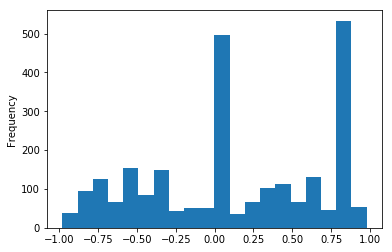

In [213]:
# Compute the sentiment scores
search_df['sentiment'] = search_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

# Plot the distribution
search_df['sentiment'].plot(kind='hist',bins=20)

## Detecting bot accounts using Bot-o-meter

Botometer is a tool developed by [researchers at Indiana University](https://osome.iuni.iu.edu/) to evaluate the likelihood of a given account being a bot ([related paper](https://arxiv.org/abs/1703.03107)) based on features like user meta-data, friends, content, sentiment, network, and timing. They provide an API as well as a [Python wrapper](https://github.com/IUNetSci/botometer-python) to use API. At the terminal command line, you'll need to:

`pip install botometer`

You will also need to request an API key from this marketplace: https://rapidapi.com/OSoMe/api/botometer

Once you've done all of this, you can start!

In [217]:
import botometer

botometer_api_key = '924e739af7msh78c742ea41f287dp121424jsnff240670ac73'

bom = botometer.Botometer(mashape_key=botometer_api_key,**twitter_keys)

We can check a single account to see the response object. [Documentation for these different response scores](https://market.mashape.com/OSoMe/botometer/overview#wiki-response-object), but the most relevant information is available under "scores" for both English-specific accounts and universal.

In [224]:
bom_result = bom.check_account('@realdonaldtrump')

bom_result

{'cap': {'english': 0.0013611897321404152, 'universal': 0.0017440333583248883},
 'categories': {'content': 0.047633403945789514,
  'friend': 0.09407699305084682,
  'network': 0.07473755397913713,
  'sentiment': 0.09212893023754924,
  'temporal': 0.11098691236375971,
  'user': 0.02392906059496764},
 'display_scores': {'content': 0.2,
  'english': 0.2,
  'friend': 0.5,
  'network': 0.4,
  'sentiment': 0.5,
  'temporal': 0.6,
  'universal': 0.1,
  'user': 0.1},
 'scores': {'english': 0.030068974042493608,
  'universal': 0.027614042942260764},
 'user': {'id_str': '25073877', 'screen_name': 'realDonaldTrump'}}

For this account, there's only a 3% chance of this account being a bot.

In [225]:
bom_result['scores']

{'english': 0.030068974042493608, 'universal': 0.027614042942260764}

Botometer is limited to 2,000 requests per day per user. Let's get the bot scores for the most-active screen names in our `search_df` sample.

In [230]:
search_screen_name_count = search_df['screen_name'].value_counts()

top_search_screen_names = search_screen_name_count[search_screen_name_count > 3].index.tolist()
top_search_screen_names

['BobbyJansen3',
 'StedeBonnet_',
 'Crunk5454',
 'rjber15',
 'ProggesiveAlien',
 'afabulousmess',
 'AmorGaia',
 'dgradost',
 'WantedSanders',
 'JD_Wallen1',
 'isavega2017',
 'emariemarshall',
 'PaulPasquariell',
 'QuillenSheri',
 'KurtWhiteside1',
 'jessica_2630',
 'walksfarforever',
 'bryceleonardo',
 'rockie_springer',
 'misterstepp',
 'somenycguy',
 'ChrisGTwoAgain',
 'LadyElirien',
 'duranceau_mike',
 'sbishop61115',
 'ILovesMyUSA',
 'tlexptmiller',
 'VixenRogue',
 'HarleyHap',
 'Workhorse95',
 'monlovchel',
 'JJMCCABE2',
 'know_me89',
 'flinn_terri',
 'MrGQ37',
 'EuclidAlone',
 'Metalworks4',
 'Christo16222780',
 'Dreisawesomek',
 'warrenwarmachi1',
 'scottmac1955',
 'Aeriqui',
 'JoellenPinter',
 'MarisolTexas',
 'ToxicExplodley',
 'renatelsj',
 'Sue95402553',
 'Damnoldguy',
 'JohnCocktoaste9',
 'Cuppy1',
 'daguz80',
 'emilawad',
 'echas3wi',
 'svitaus',
 'RickAndKim30yrs',
 'Dennis17Viper',
 'rfkjrnmphs',
 'FaxquoFax',
 'GlfLuvr1',
 'bearerofmeaning',
 'SaIIyWalker',
 'Cucknews42

Loop through these accounts and get the bot scores. This could take a few minutes.

In [234]:
top_search_screen_name_bots = bom.check_accounts_in(top_search_screen_names)

top_search_screen_name_bot_list = []

for screen_name, result in top_search_screen_name_bots:
    top_search_screen_name_bot_list.append({screen_name:result})

I've posted some bot scores for accounts to save us time.

In [241]:
with open('top_search_screen_name_bots.json','r') as f:
    top_search_screen_name_bot_list = json.load(f)

Clean up this data, turn it into a Pandas `Series`, and rank the top scores.

In [262]:
universal_scores = {}
for result in top_search_screen_name_bot_list:
    for screen_name,r in result.items():
        universal_scores[screen_name] = r['scores']['universal']

scores_s = pd.Series(universal_scores).sort_values(ascending=False)

scores_s.sort_values(ascending=False).head(20)

HarleyHap          0.857202
Sue95402553        0.771304
warrenwarmachi1    0.690802
peanutbutterisg    0.654560
MarisolTexas       0.635707
sbishop61115       0.616428
Metalworks4        0.596776
isavega2017        0.596776
flinn_terri        0.536176
SaIIyWalker        0.536176
Crunk5454          0.515643
rjber15            0.474489
RickAndKim30yrs    0.454006
tdoyle030260       0.433677
ChrisGTwoAgain     0.393746
QuillenSheri       0.393746
Christo16222780    0.374267
ILovesMyUSA        0.374267
misterstepp        0.355186
BobbyJansen3       0.355186
dtype: float64

Plot the histogram of scores.

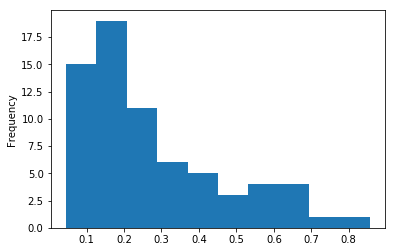

In [263]:
scores_s.plot(kind='hist',bins=10)

Let's look at the user timeline for one of these accounts.

In [265]:
# Start with the list of the 200 most-recent tweets
bot_timeline_tweets = api.GetUserTimeline(screen_name='Sue95402553',count=200,include_rts=True)

# Initialize a counter so we don't go overboard with our requests
request_counter = 1

# While our request counter hasn't gone past 16
while request_counter < 17:
    # Get the most oldest tweet id
    final_status_id = bot_timeline_tweets[-1].id
    
    # Pass this tweet ID into the max_id parameter, minus 1 so we don't duplicate it
    bot_timeline_tweets += api.GetUserTimeline(screen_name='Sue95402553',count=200,include_rts=True,max_id=final_status_id-1)
    
    # Increment our request_counter
    request_counter += 1

How many tweets?

In [334]:
"There are {0:,} tweets.".format(len(bot_timeline_tweets))

'There are 3,136 tweets.'

Re-use our code from above to flatten.

In [273]:
bot_statuses_list = []

for status in bot_timeline_tweets:
    if type(status) == twitter.models.Status:
        payload = {}
        payload['screen_name'] = status.user.screen_name
        payload['created'] = pd.to_datetime(status.created_at)
        payload['retweets'] = status.retweet_count
        payload['favorites'] = status.favorite_count
        payload['id'] = status.id
        payload['reply_screen_name'] = status.in_reply_to_screen_name
        payload['reply_id'] = status.in_reply_to_status_id
        payload['source'] = BeautifulSoup(status.source).text
        
        if len(status.user_mentions) > 0:
            payload['user_mentions'] = '; '.join([m.screen_name for m in status.user_mentions])
        else:
            payload['user_mentions'] = None
            
        if len(status.hashtags) > 0:
            payload['hashtags'] = '; '.join([h.text for h in status.hashtags])
        else:
            payload['hashtags'] = None
        
        # If an account retweets another account, we should store that information
        if status.retweeted_status == None:
            payload['text'] = status.full_text
            payload['is_retweet'] = False
            payload['retweeted_screen_name'] = False
            payload['retweeted_created'] = False
        else:
            payload['text'] = status.retweeted_status.full_text
            payload['is_retweet'] = True
            payload['retweeted_screen_name'] = status.retweeted_status.user.screen_name
            payload['retweeted_created'] = status.retweeted_status.created_at
            payload['retweeted_source'] = BeautifulSoup(status.retweeted_status.source).text
            if len(status.retweeted_status.hashtags) > 0:
                payload['hashtags'] = '; '.join([h.text for h in status.retweeted_status.hashtags])
            else:
                payload['hashtags'] = None
        
        bot_statuses_list.append(payload)
        
bot_timeline_df = pd.DataFrame(bot_statuses_list)

Clean up our DataFrame.

In [274]:
bot_timeline_df['timestamp'] = pd.to_datetime(bot_timeline_df['created'])
bot_timeline_df['timestamp'] = pd.to_datetime(bot_timeline_df['timestamp'])
bot_timeline_df['timestamp'] = bot_timeline_df['timestamp'].dt.tz_convert(None)

bot_timeline_df['date'] = bot_timeline_df['timestamp'].apply(lambda x:x.date())
bot_timeline_df['weekday'] = bot_timeline_df['timestamp'].apply(lambda x:x.weekday())
bot_timeline_df['hour'] = bot_timeline_df['timestamp'].apply(lambda x:x.hour)

bot_timeline_df['sentiment'] = bot_timeline_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

bot_timeline_df.head()

,created,favorites,hashtags,id,is_retweet,reply_id,reply_screen_name,retweeted_created,retweeted_screen_name,retweeted_source,retweets,screen_name,source,text,user_mentions,timestamp,date,weekday,hour,sentiment
0,2019-02-10 19:20:55+00:00,0,BuildTheWallCrimeWillFall,1094677613011001344,True,None,None,Sun Feb 10 16:30:36 +0000 2019,AnnaBD20,Twitter Web Client,590,Sue95402553,Twitter for Android,SHERIFFS WARN ICE COULD BE FORCED TO RELEASE 8...,AnnaBD20,2019-02-10 19:20:55,2019-02-10,6,19,-0.8910
1,2019-02-10 19:16:15+00:00,0,None,1094676439549571073,True,None,None,Sun Feb 10 17:47:10 +0000 2019,winstonCovfefe,Twitter Web Client,119,Sue95402553,Twitter for Android,Elizabeth Warren @SenWarren: We need to take p...,winstonCovfefe; SenWarren,2019-02-10 19:16:15,2019-02-10,6,19,0.5574
2,2019-02-10 19:08:44+00:00,0,DeepStateCorruption; FOXNews,1094674547754835968,True,None,None,Sun Feb 10 17:25:20 +0000 2019,Boo3zero5,Twitter for Android,172,Sue95402553,Twitter for Android,Democrats &amp; Clinton camp. committed crimes...,Boo3zero5,2019-02-10 19:08:44,2019-02-10,6,19,0.2500
3,2019-02-10 19:08:25+00:00,0,None,1094674465173180416,True,None,None,Tue Feb 05 17:35:23 +0000 2019,gaye_gallops,Twitter for iPhone,2321,Sue95402553,Twitter for Android,THE DEMOCRATIC PARTY HAS GONE FROM RADICALISM ...,gaye_gallops,2019-02-10 19:08:25,2019-02-10,6,19,-0.7656
4,2019-02-10 19:07:09+00:00,0,ChooseAmericanMetal,1094674147563716608,True,None,None,Sat May 19 17:04:02 +0000 2018,ChooseAmericanM,Sprout Social,2738,Sue95402553,Twitter for Android,"Sure, American-made steel products might cost ...",ChooseAmericanM,2019-02-10 19:07:09,2019-02-10,6,19,0.7269


Every single one of the tweets from this account is a retweet.

In [275]:
bot_timeline_df['is_retweet'].value_counts()

True    3136
Name: is_retweet, dtype: int64

All of these tweets come from a "Twitter for Android" source.

In [310]:
bot_timeline_df['source'].value_counts()

Twitter for Android    3136
Name: source, dtype: int64

Who are the account they are retweeting? Prominent conservatives.

In [276]:
bot_timeline_df['retweeted_screen_name'].value_counts().head(10)

realDonaldTrump    51
mitchellvii        51
charliekirk11      45
JackPosobiec       32
RealJamesWoods     30
JudicialWatch      26
dbongino           26
TomFitton          25
RealMattCouch      21
Lrihendry          19
Name: retweeted_screen_name, dtype: int64

What is the distribution of the time between tweets? The vast majority of the time between tweets happen less than 60 seconds apart.

Text(0.5, 0, 'Seconds between tweets')

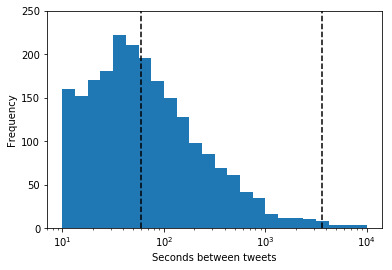

In [333]:
tweet_latencies = bot_timeline_df['timestamp'].sort_values().diff()/pd.Timedelta(1,'s')
ax = tweet_latencies.plot(kind='hist',bins=np.logspace(1,4,25))
ax.set_xscale('log')
ax.axvline(60,c='k',ls='--')
ax.axvline(3600,c='k',ls='--')
ax.set_ylim((0,250))
ax.set_xlabel('Seconds between tweets')

Given that all this account's tweets are retweets, what is the distribution of time from original tweet to its retweet? Mostly after an hour but within a day.

Text(0.5, 0, 'Seconds between tweets')

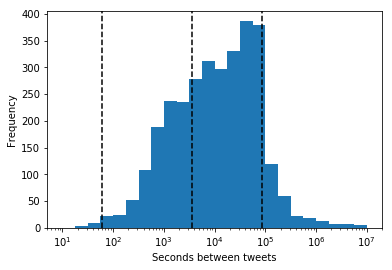

In [362]:
_s = (pd.to_datetime(bot_timeline_df['created']) - pd.to_datetime(bot_timeline_df['retweeted_created']))/pd.Timedelta(1,'s')
ax = _s.plot(kind='hist',bins=np.logspace(1,7,25))
ax.axvline(60,c='k',ls='--')
ax.axvline(3600,c='k',ls='--')
ax.axvline(86400,c='k',ls='--')
ax.set_xscale('log')
ax.set_xlabel('Seconds between tweets')


I like to make a "temporal fingerprint" of a user account to see what days of the week and hours of the day a user is active. This user appears to be most active on Wednesday afternoons. But this appears to be much more random than I would expect (weekends *vs*. weekdays, nighttime *vs*. daytime, *etc*.).

Text(133.44000000000005, 0.5, '')

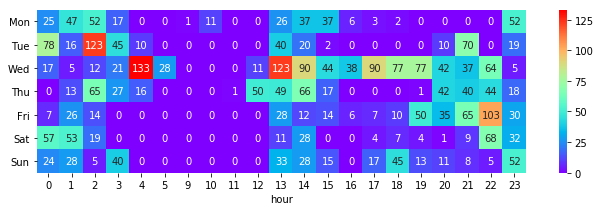

In [332]:
ct = pd.crosstab(bot_timeline_df['weekday'],bot_timeline_df['hour']).fillna(0)

f,ax = plt.subplots(1,1,figsize=(12,3))
sb.heatmap(ct,square=True,cmap='rainbow',ax=ax,annot=True,fmt='.0f')

ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation=0)
ax.set_ylabel(None)

Distribution of sentiment scores.

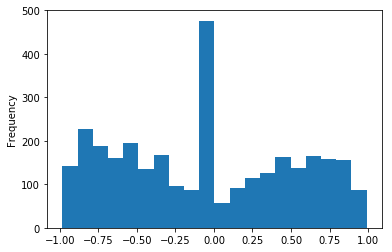

In [336]:
bot_timeline_df['sentiment'].plot(kind='hist',bins=20)

Sentiment scores over time.

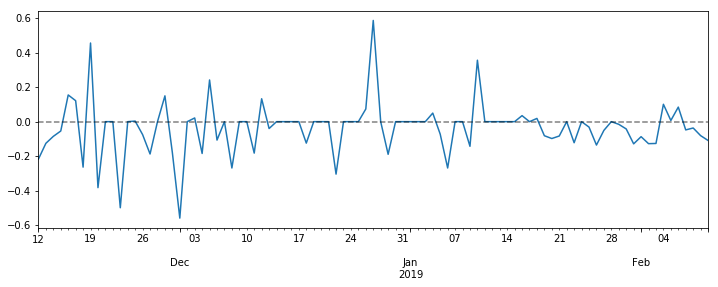

In [347]:
f,ax = plt.subplots(1,1,figsize=(12,4))
_s = bot_timeline_df.groupby('date').agg({'sentiment':'mean'})
_s = _s.reindex(pd.date_range(_s.index.min(),_s.index.max()),fill_value=0)
_s['sentiment'].plot(ax=ax)
ax.axhline(0,c='k',ls='--',alpha=.5)